# **Resnet**

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from scipy.spatial.distance import cdist

import requests
import io
from scipy.spatial.distance import cdist
import numpy as np


In [2]:
# Updated train_path to download the raw file content
train_path = f'https://github.com/psarath22/CS771_M2/raw/832c7eced7cd8dfcc800a7cfd8b772fefbf89560/dataset/part_one_dataset/train_data/1_train_data.tar.pth'
# Download the file from the URL
response = requests.get(train_path, stream=True)
response.raise_for_status()  # Raise an exception for bad responses

# Load the data from the downloaded content using io.BytesIO
train_data = torch.load(io.BytesIO(response.content))

print(train_data.keys())
print(train_data['data'].shape)
print(train_data['targets'].shape)

dict_keys(['data', 'targets'])
(2500, 32, 32, 3)
(2500,)


<ipython-input-2-b6a3d2aa1d77>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(io.BytesIO(response.content))


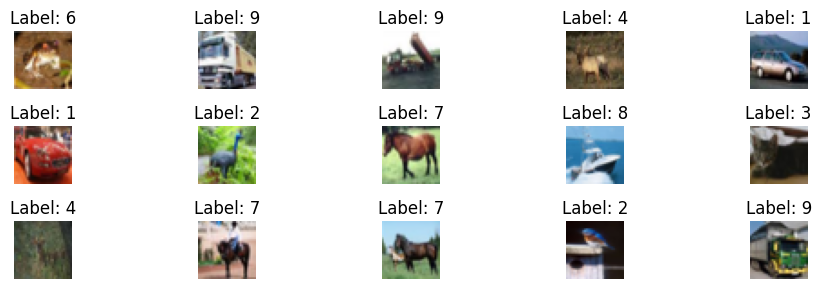

In [3]:
# Get the first 15 images and labels from train_data
images = train_data['data'][:15]
labels = train_data['targets'][:15]

# Set up a 3x5 plot
fig, axes = plt.subplots(3, 5, figsize=(10, 3))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')  # Hide the axes for a cleaner look

plt.tight_layout()
plt.show()


In [4]:
# Initialize feature extractor model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Feature extraction function
def process_and_extract_features(data, model):
    extracted_features = []
    for X in data:
        X_resized = np.array([image.img_to_array(image.array_to_img(img, scale=False).resize((180,180))) for img in X])
        X_preprocessed = preprocess_input(X_resized)
        features = model.predict(X_preprocessed, batch_size=32)
        extracted_features.append(features)
    return np.vstack(extracted_features)


In [15]:
class LwPClassifier:
    def __init__(self, metric='euclidean'):
        self.metric = metric
        self.class_prototypes = {}

    def fit(self, X, y, weights=None, alpha=0.01, max_iter=100, tol=1e-4):
        """Compute prototypes (mean vectors) for each class, with optional weighting and regularization."""
        X = X.reshape(X.shape[0], -1)  # Flatten the feature dimension
        y = np.array(y, dtype=int)  # Ensure y is a 1D array of integers

        # Initialize prototypes using weighted average if weights are provided, else use simple average
        if weights is None:
            prototypes = np.array([
                np.mean(X[y == cls], axis=0)  # Use simple average if no weights
                for cls in np.unique(y)
            ])
        else:
            # Iterative refinement (like K-means) for pseudo-labels (for datasets 2 to 10)
            prototypes = np.array([
                np.average(X[y == cls], axis=0, weights=weights[y == cls])  # Initial prototypes with weights
                for cls in np.unique(y)
            ])

            for iteration in range(max_iter):
                print(f"Iteration {iteration+1}/{max_iter}")

                # Step 1: Assign each sample to the closest prototype
                distances = cdist(X, prototypes, metric=self.metric)
                closest_prototype_idx = distances.argmin(axis=1)

                # Step 2: Update prototypes based on the assigned closest samples (weighted average)
                new_prototypes = np.array([
                    np.average(X[closest_prototype_idx == cls], axis=0, weights=weights[closest_prototype_idx == cls] if weights is not None else None)
                    if np.any(closest_prototype_idx == cls) else prototypes[cls]
                    for cls in np.unique(y)
                ])

                # Step 3: Check for convergence (if the change in prototypes is smaller than the tolerance)
                if np.all(np.abs(new_prototypes - prototypes) < tol):
                    print("Convergence reached.")
                    break

                prototypes = new_prototypes

        # Update the class prototypes after training
        self.class_prototypes = {cls: prototypes[cls] for cls in np.unique(y)}

    def predict(self, X):
        """Predict class for each sample in X."""
        X = X.reshape(X.shape[0], -1)  # Flatten the feature dimension
        prototypes = np.array([self.class_prototypes[cls] for cls in self.class_prototypes])
        distances = cdist(X, prototypes, metric=self.metric)
        closest_prototype_idx = distances.argmin(axis=1)
        return np.array([cls for cls in self.class_prototypes])[closest_prototype_idx]


In [6]:
# Initialize accuracy matrix and define number of models
num_models = 20
accuracy_matrix = np.zeros((num_models, num_models))

# Helper functions to get data and labels in appropriate format
def get_data_fn1(data):
    return data['data']

def get_data_fn2(data):
    return data['data'], data['targets']


In [7]:
# Pre-extract features for all training and evaluation datasets
train_data_extracted = {}
eval_data_extracted = {}
labels_train = {}
labels_eval = {}

In [14]:
# Pre-process train datasets
for i in range(1, 21):
    if i <= 10:
        train_path = f'https://github.com/psarath22/CS771_M2/raw/832c7eced7cd8dfcc800a7cfd8b772fefbf89560/dataset/part_one_dataset/train_data/{i}_train_data.tar.pth'  # Use 'raw' instead of 'blob'
    else:
        train_path = f'https://github.com/psarath22/CS771_M2/raw/832c7eced7cd8dfcc800a7cfd8b772fefbf89560/dataset/part_two_dataset/train_data/{i-10}_train_data.tar.pth'  # Use 'raw' instead of 'blob'


    if i==1:
        response = requests.get(train_path, stream=True)
        train_data = torch.load(io.BytesIO(response.content))
        X_train,Y_train = get_data_fn2(train_data)
        X_train_features = process_and_extract_features([X_train], model)
        labels_train[i] = Y_train
    else:
        response = requests.get(train_path, stream=True)
        train_data = torch.load(io.BytesIO(response.content))
        X_train = get_data_fn1(train_data)
        X_train_features = process_and_extract_features([X_train], model)

    train_data_extracted[i] = X_train_features

# Pre-process+ eval datasets
for i in range(1, 21):
    if i <= 10:
        eval_path = f'https://github.com/psarath22/CS771_M2/raw/832c7eced7cd8dfcc800a7cfd8b772fefbf89560/dataset/part_one_dataset/eval_data/{i}_eval_data.tar.pth'
    else:
        eval_path = f'https://github.com/psarath22/CS771_M2/raw/832c7eced7cd8dfcc800a7cfd8b772fefbf89560/dataset/part_two_dataset/eval_data/{i-10}_eval_data.tar.pth'

    response = requests.get(eval_path, stream=True)
    response.raise_for_status()  # Raise an exception for bad responses

    eval_data = torch.load(io.BytesIO(response.content))
    X_valid, Y_valid = get_data_fn2(eval_data)
    X_valid_features = process_and_extract_features([X_valid], model)

    eval_data_extracted[i] = X_valid_features
    labels_eval[i] = Y_valid


<ipython-input-14-73be9aef4890>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(io.BytesIO(response.content))


79/79 [==============================] - 32s 407ms/step


<ipython-input-14-73be9aef4890>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(io.BytesIO(response.content))


79/79 [==============================] - 32s 410ms/step


<ipython-input-14-73be9aef4890>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eval_data = torch.load(io.BytesIO(response.content))


79/79 [==============================] - 32s 399ms/step


In [9]:
print(train_data_extracted[1].shape)

(2500, 2048)


In [10]:
# Initialize classifier and train on the first dataset
classifier = LwPClassifier(metric='euclidean')
classifier.fit(train_data_extracted[1], labels_train[1])

# Evaluate on the first dataset
valid_predictions_1 = classifier.predict(eval_data_extracted[1])
valid_accuracy_1 = accuracy_score(labels_eval[1], valid_predictions_1)
accuracy_matrix[0, 0] = valid_accuracy_1
print(f"Model f1: Validation Accuracy on D1 = {valid_accuracy_1:.2f}")

Model f1: Validation Accuracy on D1 = 0.84


In [11]:
# Train and evaluate models on subsequent datasets
for i in range(2, 21):
    X_train = train_data_extracted[i]

    # Generate pseudo-labels and update prototypes
    pseudo_labels = classifier.predict(X_train)
    X_combined = X_train
    Y_combined = pseudo_labels
    classifier.fit(X_combined, Y_combined)  # Update prototypes with combined data

    # Evaluate the current model on the current and all previous validation sets
    for j in range(1, i + 1):
        X_valid_j = eval_data_extracted[j]
        Y_valid_j = labels_eval[j]

        valid_predictions = classifier.predict(X_valid_j)
        valid_accuracy = accuracy_score(Y_valid_j, valid_predictions)
        accuracy_matrix[i - 1, j - 1] = valid_accuracy


In [12]:
# Print accuracies row-wise
for i in range(num_models):
    print(f"Accuracies for model f{i+1}: {accuracy_matrix[i, :i+1]}")


Accuracies for model f1: [0.8372]
Accuracies for model f2: [0.7988 0.798 ]
Accuracies for model f3: [0.784  0.7736 0.7808]
Accuracies for model f4: [0.768  0.7664 0.7764 0.7568]
Accuracies for model f5: [0.7612 0.7504 0.7648 0.7484 0.7688]
Accuracies for model f6: [0.7548 0.742  0.7596 0.7472 0.76   0.7512]
Accuracies for model f7: [0.7544 0.7424 0.7552 0.7368 0.7604 0.7576 0.7444]
Accuracies for model f8: [0.7492 0.7392 0.7528 0.7364 0.7544 0.7508 0.7424 0.7468]
Accuracies for model f9: [0.7368 0.7424 0.7496 0.7328 0.756  0.752  0.7344 0.7416 0.724 ]
Accuracies for model f10: [0.7504 0.7344 0.7456 0.7396 0.7556 0.7468 0.7316 0.7376 0.7204 0.7536]
Accuracies for model f11: [0.6812 0.6796 0.6996 0.6728 0.6936 0.6908 0.6756 0.6836 0.668  0.6964
 0.5608]
Accuracies for model f12: [0.5632 0.5584 0.5576 0.5552 0.5532 0.5668 0.5464 0.552  0.5536 0.5788
 0.4552 0.4372]
Accuracies for model f13: [0.6016 0.6008 0.6076 0.5996 0.61   0.626  0.6104 0.6156 0.5852 0.63
 0.5112 0.418  0.5448]
Accurac

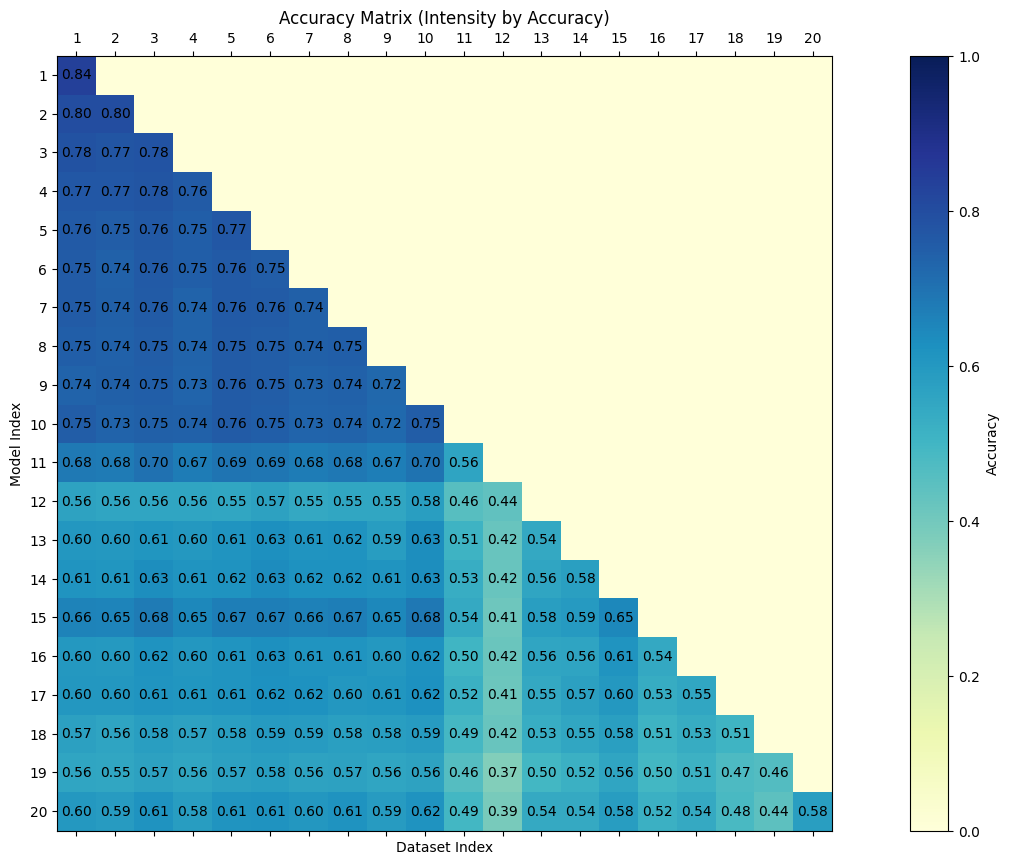

In [13]:
# Plotting the accuracy matrix as a heatmap
plt.figure(figsize=(20, 10))
heatmap = plt.matshow(accuracy_matrix, cmap='YlGnBu', fignum=1, vmin=0, vmax=1.0)  # Set color range from 0.6 to 1.0

# Add color bar for reference with accuracy label
plt.colorbar(heatmap, label='Accuracy')

# Add annotations to each cell with the accuracy values
for i in range(num_models):
    for j in range(i + 1):  # Only show lower triangle values
        plt.text(j, i, f"{accuracy_matrix[i, j]:.2f}", ha='center', va='center', color="black")

# Adjust tick labels to start from 1 instead of 0
plt.xticks(ticks=range(num_models), labels=range(1, num_models + 1))
plt.yticks(ticks=range(num_models), labels=range(1, num_models + 1))

# Set axis labels
plt.xlabel("Dataset Index")
plt.ylabel("Model Index")
plt.title("Accuracy Matrix (Intensity by Accuracy)")

# Show the plot
plt.show()